# Make paper figure
A simple notebook to prepare a figure for the [JOSE](https://jose.theoj.org/) paper.

In [1]:
using DIVAnd
using Makie, CairoMakie, GeoMakie
using Dates
using ColorSchemes
using Statistics
using GeoDatasets
using JupyterFormatter
enable_autoformat()
cmapS = ColorSchemes.haline
include("../config.jl")

"https://dox.uliege.be/index.php/s/qJtEotmkCZVqcx8/download"

In [2]:
dx, dy = 0.05, 0.05
lonr = 11.5:dx:20
latr = 39:dy:46
depthr = [0.0, 10.0, 20.0];

## Extract land-sea mask (high-res)

In [4]:
lonmask, latmask, mask = GeoDatasets.landseamask(; resolution = 'f', grid = 1.25)
goodlon = findall((lonmask .>= lonr[1]) .& (lonmask .<= lonr[end]))
goodlat = findall((latmask .>= latr[1]) .& (latmask .<= latr[end]))
lonmask = lonmask[goodlon]
latmask = latmask[goodlat]
mask = mask[goodlon, goodlat];
mask[mask.==2] .= 1;

## Read observations

In [5]:
datafile = adriaticfile
download_check(datafile, adriaticfileURL)
bathfile = gebco04file
download_check(bathfile, gebco04fileURL)

[ Info: File already downloaded
[ Info: File already downloaded


In [6]:
@time obsval, obslon, obslat, obsdepth, obstime, obsid =
    NCODV.load(Float64, datafile, "Water body salinity");

27540 out of 34709 - 79.34541473393068 %
 13.534603 seconds (13.56 M allocations: 932.257 MiB, 10.92% gc time, 70.59% compilation time)


### Subsetting

In [ ]:
sel = findall((obsdepth .<= 5.0) .& (Dates.month.(obstime) .== 4));
@info("Found $(length(sel)) obs.")

## Metrics and mask

In [7]:
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(lonr, latr);

In [8]:
bx, by, mask0 = load_mask(bathfile, true, lonr, latr, 0.0)

(11.5:0.05:20.0, 39.0:0.05:46.0, Bool[1 1 … 0 0; 1 1 … 0 0; … ; 1 1 … 0 0; 1 1 … 0 0])

In [9]:
mask_edit = copy(mask0);
grid_bx = [i for i in bx, j in by];
grid_by = [j for i in bx, j in by];
sel_mask1 = (grid_by .<= 42.6) .& (grid_bx .<= 14.0);
sel_mask2 = (grid_by .<= 41.2) .& (grid_bx .<= 16.2);
mask_edit = mask_edit .* .!sel_mask1 .* .!sel_mask2;

## Analysis

In [13]:
fi, s = DIVAndrun(
    mask_edit,
    (pm, pn),
    (xi, yi),
    (obslon[sel], obslat[sel]),
    obsval[sel] .- mean(obsval[sel]),
    (2.5, 2.5),
    0.5,
);

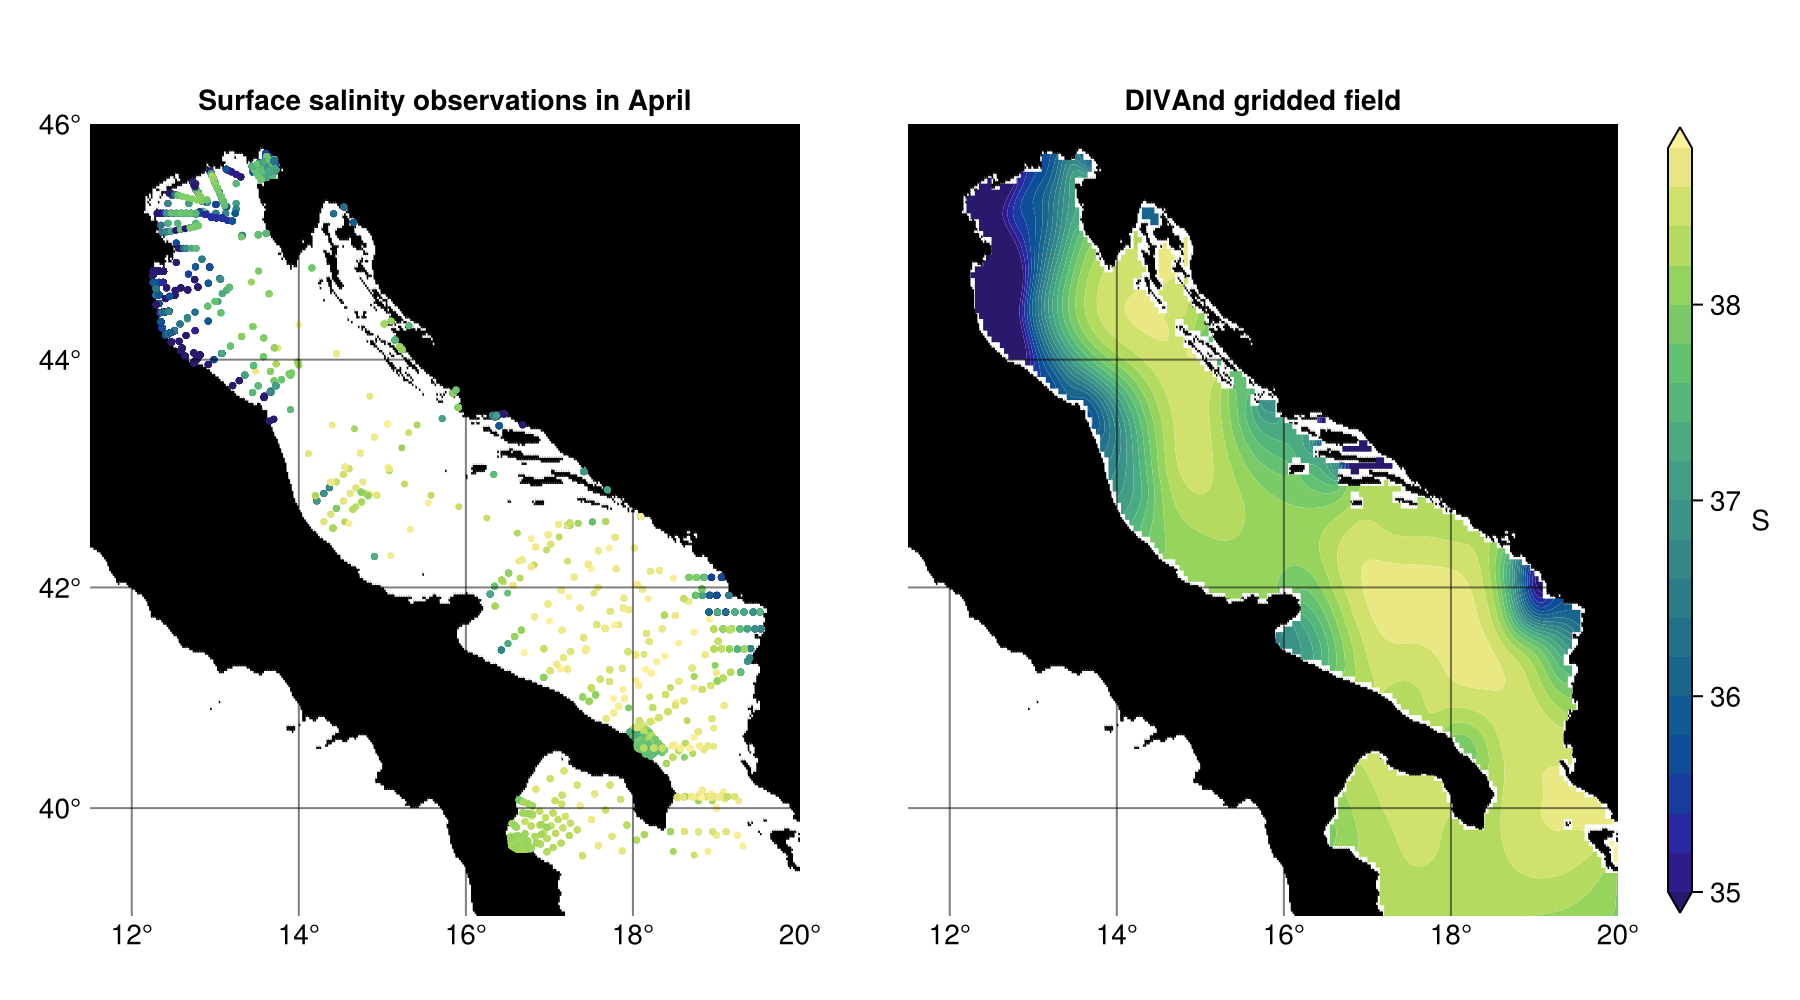

In [37]:
fig = Figure(size = (900, 500))
ga1 = GeoAxis(
    fig[1, 1],
    dest = "+proj=merc",
    title = "Surface salinity observations in April",
    xticks = 10.0:2.0:20.0,
    yticks = 38.0:2.0:48.0,
)
GeoMakie.heatmap!(ga1, lonmask, latmask, mask, colormap = :binary)
sc = scatter!(
    ga1,
    obslon[sel],
    obslat[sel],
    color = obsval[sel],
    markersize = 5,
    colorrange = (35, 38.80),
    colormap = cmapS,
)
xlims!(ga1, lonr[1], lonr[end])
ylims!(ga1, latr[1], latr[end])
# Colorbar(fig[1, 2], sc)

ga2 = GeoAxis(
    fig[1, 2],
    dest = "+proj=merc",
    title = "DIVAnd gridded field",
    xticks = 10.0:2.0:20.0,
    yticks = 38.0:2.0:48.0,
)
GeoMakie.heatmap!(ga2, lonmask, latmask, mask, colormap = :binary)
hm = contourf!(
    ga2,
    lonr,
    latr,
    fi .+ mean(obsval[sel]),
    levels = 35:0.2:38.8,
    colormap = cmapS,
    extendhigh = :auto,
    extendlow = :auto,
)
xlims!(ga2, lonr[1], lonr[end])
ylims!(ga2, latr[1], latr[end])
hideydecorations!(ga2, grid = false, ticks = true)
Colorbar(fig[1, 3], hm, label = "S", labelrotation = 0)
save(joinpath(figdir, "salinity_gridded.png"), fig)
fig

In [21]:
?contourf

ErrorException: Parsing error for input occurred on line 1, offset: 1